In [35]:
import joblib
import pandas as pd
from imblearn.over_sampling import SMOTE

In [36]:
df =  pd.read_csv(r"../data/MIT-BIH Arrhythmia Database.csv")

In [37]:
y = df['type']
df = df.drop(columns=['type', 'record'])

In [39]:
import sys
sys.path.append("../src")

preprocessing = joblib.load("../models/preprocessing_pipeline.pkl")
df_processed = preprocessing.transform(df)

In [40]:
label_ecnode = joblib.load("../models/label_encoder.pkl")
y_encoded = label_ecnode.transform(y)

In [41]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_processed, y_encoded)

In [42]:
y_labels = label_ecnode.inverse_transform(y_resampled)
label_counts = pd.Series(y_labels).value_counts()
label_counts

N       90083
Q       90083
SVEB    90083
VEB     90083
F       90083
Name: count, dtype: int64

## Split the data --> train and test

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Train The model 

In [44]:
from sklearn.metrics import accuracy_score

### K nearest neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knnclassifier = KNeighborsClassifier()
knnclassifier.fit(X_train, y_train)
y_pred_knn = knnclassifier.predict(X_test)
acc = accuracy_score(y_test,y_pred_knn)
print("Accuracy:", acc)

Accuracy: 0.9963922160674045


### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_RF = rf_clf.predict(X_test)
accuracy_score(y_test,y_pred_RF)
acc = accuracy_score(y_test,y_pred_RF)
print("Accuracy:", acc)

Accuracy: 0.9983015663332704


### Gradient Boosting

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", acc)

Accuracy: 0.9986012899215169


## Accuarcy 

In [15]:
from sklearn.metrics import accuracy_score
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_rf = accuracy_score(y_test, y_pred_RF)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy KNN:", accuracy_knn)
print("Accuracy RF:", accuracy_rf)
print("Accuracy XGB:", accuracy_xgb)

Accuracy KNN: 0.9963922160674045
Accuracy RF: 0.9983015663332704
Accuracy XGB: 0.9986012899215169


## Recall

In [16]:
from sklearn.metrics import recall_score
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
recall_rf = recall_score(y_test, y_pred_RF, average='macro')
recall_xgb = recall_score(y_test, y_pred_xgb, average='macro')
print("Recall KNN:", recall_knn)
print("Recall RF:", recall_rf)
print("Recall XGB:", recall_xgb)

Recall KNN: 0.99639209714705
Recall RF: 0.99830151716294
Recall XGB: 0.9986012538138688


## Precision

In [17]:
from sklearn.metrics import precision_score
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
precision_rf = precision_score(y_test, y_pred_RF, average='macro')
precision_xgb = precision_score(y_test, y_pred_xgb, average='macro')
print("Precision KNN:", precision_knn)
print("Precision RF:", precision_rf)
print("Precision XGB:", precision_xgb)

Precision KNN: 0.9964139146995101
Precision RF: 0.9983024662202779
Precision XGB: 0.9986012523401733


In [20]:
"""
 - We want to know if we can make an ensemble model by combining predictions from KNN, Random Forest, and XGBoost.
 - To help decide, we're analyzing how much the models agree or disagree on their mistakes.
 - If the models make different errors, an ensemble might improve performance by compensating for individual model weaknesses.
 - But if they all make the same errors, the ensemble likely won't add much benefit.
"""
from sklearn.metrics import confusion_matrix

y_pred_knn = knnclassifier.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

errors_knn = (y_pred_knn != y_test)
errors_rf = (y_pred_rf != y_test)
errors_xgb = (y_pred_xgb != y_test)

import numpy as np
common_errors = np.logical_and(errors_knn, errors_rf, errors_xgb)

print("number of common errors  :", np.sum(common_errors))
print("number of different errors for each model:")
print("KNN:", np.sum(errors_knn))
print("RF :", np.sum(errors_rf))
print("XGB:", np.sum(errors_xgb))


number of common errors  : 93
number of different errors for each model:
KNN: 325
RF : 153
XGB: 93


هنلاحظ هنا ان فيه 93 غلطه مشتركين فيها كلهم و تلاحظ ان 
XGB غلطهم كلهم اما الباقي ف غلطوا ف حاجات تانيه اكتر 
و دا معناه ان ال XGB هو افضلهم ف هنستخدمه هو افضل

## Fine Tuning XGBoost Using RandomizedSearchCV

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb = XGBClassifier(eval_metric='logloss')

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='accuracy',  
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Score: 0.9985846379640808


In [22]:
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18017
           1       1.00      1.00      1.00     18016
           2       1.00      1.00      1.00     18017
           3       1.00      1.00      1.00     18017
           4       1.00      1.00      1.00     18016

    accuracy                           1.00     90083
   macro avg       1.00      1.00      1.00     90083
weighted avg       1.00      1.00      1.00     90083



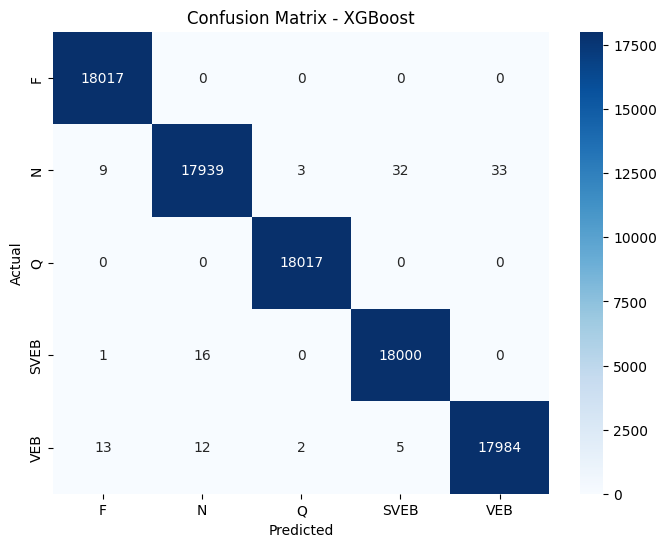

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_ecnode.classes_, 
            yticklabels=label_ecnode.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_xgb, target_names=label_ecnode.classes_))

              precision    recall  f1-score   support

           F       1.00      1.00      1.00     18017
           N       1.00      1.00      1.00     18016
           Q       1.00      1.00      1.00     18017
        SVEB       1.00      1.00      1.00     18017
         VEB       1.00      1.00      1.00     18016

    accuracy                           1.00     90083
   macro avg       1.00      1.00      1.00     90083
weighted avg       1.00      1.00      1.00     90083



In [45]:
best_xgb = XGBClassifier(
    subsample=0.8,
    reg_lambda=1,
    reg_alpha=0,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.2,
    gamma=0.1,
    colsample_bytree=1.0,
    eval_metric='logloss'
)

best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

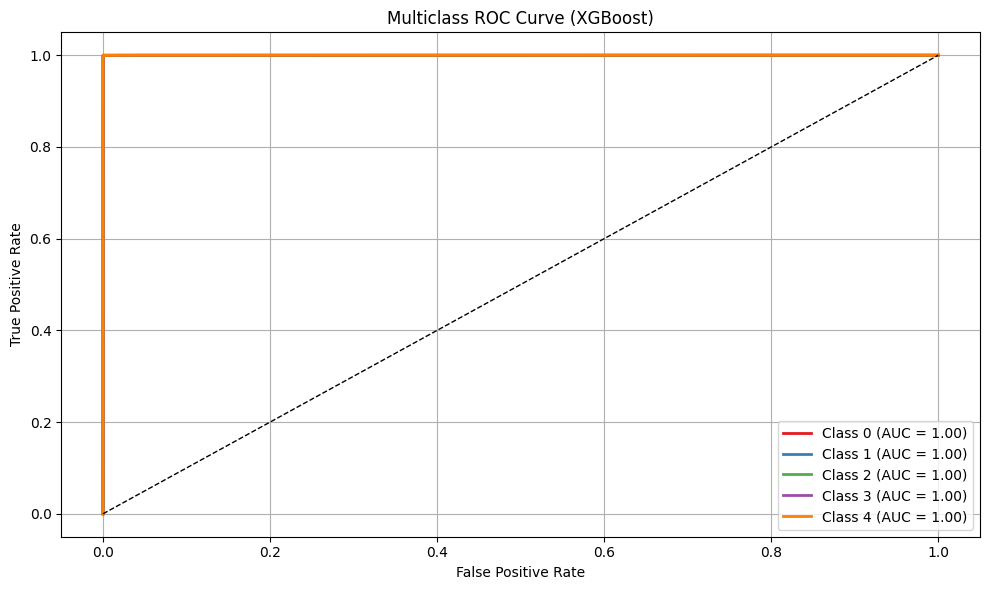

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_prob = best_xgb.predict_proba(X_test)

n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set1", n_colors=n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("Multiclass ROC Curve (XGBoost)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
print("Train accuracy:", best_xgb.score(X_train, y_train))
print("Test accuracy:", best_xgb.score(X_test, y_test))

Train accuracy: 0.9999972247815904
Test accuracy: 0.9989454170043183


In [53]:
importances = best_xgb.feature_importances_
for name, score in zip(pd.DataFrame(X_train).columns, importances):
    print(f"{name}: {score:.4f}")

0: 0.0654
1: 0.0151
2: 0.0130
3: 0.0222
4: 0.0077
5: 0.0310
6: 0.0133
7: 0.0467
8: 0.0806
9: 0.0255
10: 0.0146
11: 0.0188
12: 0.0411
13: 0.0471
14: 0.0104
15: 0.0162
16: 0.0795
17: 0.0245
18: 0.0491
19: 0.0070
20: 0.0089
21: 0.0147
22: 0.0926
23: 0.0889
24: 0.0134
25: 0.0391
26: 0.0124
27: 0.0559
28: 0.0063
29: 0.0222
30: 0.0166


ممتاز، دي قيم feature importance من موديل XGBoost، ومفيش فيهم حاجة شاذة جدًا أو واضحة إنها leak مباشر (يعني مفيش واحدة واخدة 0.99 مثلاً والباقي صفر).

## Full Pipeline

In [46]:
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', best_xgb)])

In [47]:
joblib.dump(full_pipeline, '../models/xgboost_pipeline.pkl')

['../models/xgboost_pipeline.pkl']